In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import  transforms, datasets

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr
        
        #Define layers
        
        #Contracting path
        self.enc1_1 = CBR2d(in_channels=2, out_channels=64)       #neuron image 를 add 해서 2채널로 만들기
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels=1024)
        
        #CenterCropping 
#         self.crop4 = transforms.CenterCrop(56)
#         self.crop3 = transforms.CenterCrop(104)
#         self.crop2 = transforms.CenterCrop(200)
#         self.crop1 = transforms.CenterCrop(388)  # input size 512*512 기준
        
        #Expanding path
        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec4_2 = CBR2d(in_channels=1024, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=512)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=512, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=256)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=256, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=128)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=128, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=1,
                                 kernel_size=1, stride=1, padding=0,
                                 bias=True)
        self.out_1 = nn.BatchNorm2d(num_features=1)
        self.out = nn.Sigmoid()
        
    #forwarding
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)
            
        unpool4 = self.unpool4(enc5_2)
        # concatenate croped_enc4_2
        crop4 = enc4_2#[:, :, 4:60, 4:60]
        refine4 = torch.cat((crop4, unpool4), dim=1) #dim 0,1,2,3 = batch,channel,width,height
        dec4_2 = self.dec4_2(refine4) 
        dec4_1 = self.dec4_1(dec4_2)
        unpool3 = self.unpool3(dec4_1)
        #concatenate croped_enc3_2
        crop3 = enc3_2#[:, :, 16:120, 16:120]
        refine3 = torch.cat((crop3, unpool3), dim=1)
        dec3_2 = self.dec3_2(refine3)
        dec3_1 = self.dec3_1(dec3_2)
        unpool2 = self.unpool2(dec3_1)
        #concatenate croped_enc2_2
        crop2 = enc2_2#[:, :, 40:240, 40:240]
        refine2 = torch.cat((crop2, unpool2), dim=1)
        dec2_2 = self.dec2_2(refine2)
        dec2_1 = self.dec2_1(dec2_2)
        unpool1 = self.unpool1(dec2_1)
        #concatenate croped_enc1_2
        crop1 = enc1_2#[:, :, 88:480, 88:480]
        refine1 = torch.cat((crop1, unpool1), dim=1)
        dec1_2 = self.dec1_2(refine1)
        dec1_1 = self.dec1_1(dec1_2)
        
        conv1 = self.conv1(dec1_1)
        out_1 = self.out_1(conv1)
        out = self.out(out_1)


        return out
        

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        
        # 문자열 검사해서 'label'이 있으면 True 
        # 문자열 검사해서 'train'이 있으면 True
        # 문자열 검사해서 'venus'이 있으면 True
        lst_label = [f for f in lst_data if f.startswith('label2')] 
        lst_input = [f for f in lst_data if f.startswith('train')] 
        lst_venus = [f for f in lst_data if f.startswith('venus')]
        
        lst_label.sort()
        lst_input.sort()
        lst_venus.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input
        self.lst_venus = lst_venus
    
    def __len__(self):   
        return len(self.lst_label)
    
    # 데이터 load 파트
    def __getitem__(self, index):

        label_img = Image.open(os.path.join(self.data_dir, self.lst_label[index]))
        label = np.array(label_img.getdata())
        label = np.reshape(label, (512,512))
        
        input_img = Image.open(os.path.join(self.data_dir, self.lst_input[index]))
        inputs = np.array(input_img.getdata())
        inputs = np.reshape(inputs, (512,512))
        
        venus_img = Image.open(os.path.join(self.data_dir, self.lst_venus[index]))
        venus = np.array(venus_img.getdata())
        venus = np.reshape(venus, (512,512))
    
        #label = np.load(os.path.join(self.data_dir, self.lst_label[index]), allow_pickle=True)
        #inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]), allow_pickle=True)
        
        
        # normalize, 이미지는 0~255 값을 가지고 있어 이를 0~1사이로 scaling
        #label = label/255.0, label은 어차피 1, input은 최대값을 기준으로 normalize
        inputs = inputs.astype(np.float32)
        inputs = inputs/np.max(inputs)
        label = label.astype(np.float32)
        venus = venus.astype(np.float32)
        venus = venus/np.max(venus)
        

        
        # 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
        # 파이토치 인풋 format (batch, 채널, 행, 열)
        
        if label.ndim == 2:
            label = label[:,:,np.newaxis]    #파이토치 인풋 포맷을 보고도 맨 뒤에 새로운 축을 생성하는 이유는 다음 class에서 확인하기
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 
        if venus.ndim == 2:  
            venus = venus[:,:,np.newaxis]
            
        #concatenate to total input
        
        merged_input = np.concatenate((inputs, venus), axis=2)
        
        data = {'input':merged_input, 'label':label}

        # transform에 할당된 class 들이 호출되면서 __call__ 함수 실행
        if self.transform:
            data = self.transform(data)
    
        return data

In [5]:
class ToTensor(object):
    def __call__(self, data):
        label, inputs = data['label'], data['input']
   
        # numpy와 tensor의 배열 차원 순서가 다르다. 
        # numpy : (행, 열, 채널)
        # tensor : (채널, 행, 열)
        # 따라서 위 순서에 맞춰 transpose
        
        label = label.transpose((2, 0, 1)).astype(np.float32) 
        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        
        # 이후 np를 tensor로 바꾸는 코드는 다음과 같이 간단하다.
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(inputs)}

        return data

In [6]:
## 하이퍼 파라미터 설정
lr = 1e-3
batch_size = 4
num_epoch = 150

data_dir = './data'
ckpt_dir = './ckpt0311'
log_dir = './log'
res_dir = '/result'

patience = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# transform 적용해서 데이터 셋 불러오기
#transform = transforms.Compose(transforms.Normalize(0.5, 0.5), ToTensor())
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'),transform=ToTensor())

# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
#for i, data in enumerate(loader_train,1):
#    print(data['label'].size())
# val set도 동일하게 진행
dataset_val = Dataset(data_dir=os.path.join(data_dir,'val'),transform = ToTensor())
loader_val = DataLoader(dataset_val, batch_size=1 , shuffle=True)

# 네트워크 불러오기
net = UNet().to(device) # device : cpu or gpu

# loss 정의
fn_loss = nn.MSELoss().to(device)

# Optimizer 정의
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# 기타 variables 설정
num_train = len(dataset_train)
num_val = len(dataset_val)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/batch_size)

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# Tensorbord
writer_train = SummaryWriter(log_dir = os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))

In [12]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({'net':net.state_dict()},'%s'%(self.path))
        self.val_loss_min = val_loss

In [13]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str,isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

early_stopping = EarlyStopping(patience = patience, verbose = True)

# 네트워크 학습시키기
start_epoch = 0
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기  
        inputs = data['input'].to(device)
        output = net(inputs) 
        #plt.imshow(index[0,0,:,:], cmap='gray')

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        print(loss.item())
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

#         writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
#         writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
#         writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    
    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss 
            loss = fn_loss(fn_classifier(output),label)
            loss_arr += [loss.item()]     
            print('valid : epoch %04d / %04d | Batch %04d \ %f | Loss %f'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

#             writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
#             writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
#             writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
        
        early_stopping(np.mean(loss_arr), net)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

435.8768310546875
1328.009033203125
504.39697265625
773.2009887695312
valid : epoch 0001 / 0150 | Batch 0001 \ 1.000000 | Loss 887.958740
valid : epoch 0001 / 0150 | Batch 0002 \ 1.000000 | Loss 651.522812
Validation loss decreased (inf --> 651.522812).  Saving model ...
512.2406005859375
844.3394165039062
1035.964599609375
520.2659912109375
valid : epoch 0002 / 0150 | Batch 0001 \ 1.000000 | Loss 887.959961
valid : epoch 0002 / 0150 | Batch 0002 \ 1.000000 | Loss 651.521179
Validation loss decreased (651.522812 --> 651.521179).  Saving model ...
555.9168701171875
985.8697509765625
827.49365234375
565.3642578125
valid : epoch 0003 / 0150 | Batch 0001 \ 1.000000 | Loss 887.930359
valid : epoch 0003 / 0150 | Batch 0002 \ 1.000000 | Loss 651.506836
Validation loss decreased (651.521179 --> 651.506836).  Saving model ...
719.5875244140625
1183.466064453125
320.6669921875
856.3170166015625
valid : epoch 0004 / 0150 | Batch 0001 \ 1.000000 | Loss 415.076233
valid : epoch 0004 / 0150 | Batch 

819.8756713867188
811.50634765625
591.660888671875
856.1190795898438
valid : epoch 0034 / 0150 | Batch 0001 \ 1.000000 | Loss 415.039886
valid : epoch 0034 / 0150 | Batch 0002 \ 1.000000 | Loss 651.481308
EarlyStopping counter: 9 out of 150
529.6143798828125
879.9317626953125
785.802734375
911.5076904296875
valid : epoch 0035 / 0150 | Batch 0001 \ 1.000000 | Loss 415.013916
valid : epoch 0035 / 0150 | Batch 0002 \ 1.000000 | Loss 651.431091
EarlyStopping counter: 10 out of 150
722.1441650390625
735.6615600585938
812.6114501953125
761.3408813476562
valid : epoch 0036 / 0150 | Batch 0001 \ 1.000000 | Loss 887.891846
valid : epoch 0036 / 0150 | Batch 0002 \ 1.000000 | Loss 651.460693
EarlyStopping counter: 11 out of 150
674.0310668945312
649.2896118164062
972.0059814453125
711.5028076171875
valid : epoch 0037 / 0150 | Batch 0001 \ 1.000000 | Loss 887.872681
valid : epoch 0037 / 0150 | Batch 0002 \ 1.000000 | Loss 651.455078
EarlyStopping counter: 12 out of 150
558.8397216796875
1153.27136

845.79541015625
635.34326171875
777.9735717773438
783.5850830078125
valid : epoch 0067 / 0150 | Batch 0001 \ 1.000000 | Loss 414.970154
valid : epoch 0067 / 0150 | Batch 0002 \ 1.000000 | Loss 651.377777
EarlyStopping counter: 2 out of 150
734.34814453125
355.32647705078125
1168.0074462890625
786.52001953125
valid : epoch 0068 / 0150 | Batch 0001 \ 1.000000 | Loss 414.999390
valid : epoch 0068 / 0150 | Batch 0002 \ 1.000000 | Loss 651.415405
EarlyStopping counter: 3 out of 150
872.1983642578125
548.8988647460938
836.578125
786.520751953125
valid : epoch 0069 / 0150 | Batch 0001 \ 1.000000 | Loss 414.988098
valid : epoch 0069 / 0150 | Batch 0002 \ 1.000000 | Loss 651.392578
EarlyStopping counter: 4 out of 150
555.7256469726562
583.84765625
948.1531982421875
1126.5068359375
valid : epoch 0070 / 0150 | Batch 0001 \ 1.000000 | Loss 888.168030
valid : epoch 0070 / 0150 | Batch 0002 \ 1.000000 | Loss 651.578369
EarlyStopping counter: 5 out of 150
843.2554931640625
899.6121215820312
516.30993

844.292236328125
829.1297607421875
549.3619384765625
856.023193359375
valid : epoch 0101 / 0150 | Batch 0001 \ 1.000000 | Loss 887.789307
valid : epoch 0101 / 0150 | Batch 0002 \ 1.000000 | Loss 651.380249
EarlyStopping counter: 2 out of 150
864.832275390625
307.9252624511719
1091.638916015625
772.8275146484375
valid : epoch 0102 / 0150 | Batch 0001 \ 1.000000 | Loss 414.964844
valid : epoch 0102 / 0150 | Batch 0002 \ 1.000000 | Loss 651.366394
Validation loss decreased (651.375153 --> 651.366394).  Saving model ...
574.7054443359375
673.9541625976562
1269.92333984375
264.48565673828125
valid : epoch 0103 / 0150 | Batch 0001 \ 1.000000 | Loss 414.968567
valid : epoch 0103 / 0150 | Batch 0002 \ 1.000000 | Loss 651.372314
EarlyStopping counter: 1 out of 150
516.74658203125
582.5888671875
1081.85009765625
939.2142944335938
valid : epoch 0104 / 0150 | Batch 0001 \ 1.000000 | Loss 887.775330
valid : epoch 0104 / 0150 | Batch 0002 \ 1.000000 | Loss 651.370148
EarlyStopping counter: 2 out of 

valid : epoch 0134 / 0150 | Batch 0002 \ 1.000000 | Loss 651.367676
EarlyStopping counter: 11 out of 150
380.1953125
789.9725952148438
1054.022216796875
853.047607421875
valid : epoch 0135 / 0150 | Batch 0001 \ 1.000000 | Loss 414.970673
valid : epoch 0135 / 0150 | Batch 0002 \ 1.000000 | Loss 651.367294
EarlyStopping counter: 12 out of 150
910.2615966796875
781.6673583984375
601.0790405273438
715.3545532226562
valid : epoch 0136 / 0150 | Batch 0001 \ 1.000000 | Loss 414.961853
valid : epoch 0136 / 0150 | Batch 0002 \ 1.000000 | Loss 651.362183
Validation loss decreased (651.363693 --> 651.362183).  Saving model ...
890.0199584960938
758.8389892578125
707.0357055664062
589.5721435546875
valid : epoch 0137 / 0150 | Batch 0001 \ 1.000000 | Loss 887.772217
valid : epoch 0137 / 0150 | Batch 0002 \ 1.000000 | Loss 651.368011
EarlyStopping counter: 1 out of 150
750.8406372070312
818.953369140625
693.9281005859375
773.906982421875
valid : epoch 0138 / 0150 | Batch 0001 \ 1.000000 | Loss 414.9

loss is 0.057449 
accuracy is 0.942551 


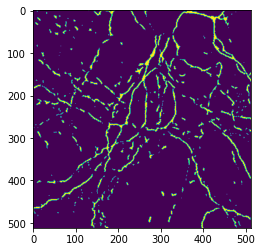

loss is 0.078918 
accuracy is 0.921082 


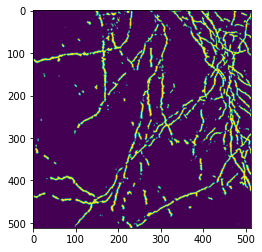

loss is 0.073818 
accuracy is 0.926182 


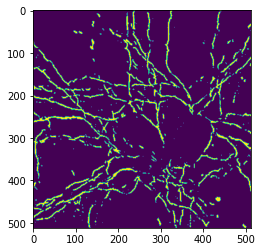

loss is 0.065517 
accuracy is 0.934483 


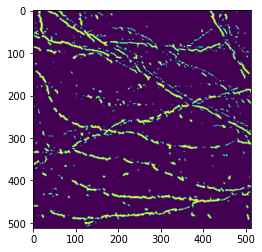

In [14]:
#Let's test
dict_model = torch.load('%s/%s' % (ckpt_dir,'model_epoch120.pth'))

net.load_state_dict(dict_model['net'])
cnt = 1
# test set도 동일하게 진행
dataset_test = Dataset(data_dir=os.path.join(data_dir,'test'),transform = ToTensor())
loader_test = DataLoader(dataset_test, batch_size=1 , shuffle=False)

for batch, data in enumerate(loader_test,1):
    # forward
    label = data['label'].to(device)
    inputs = data['input'].to(device)
    output = net(inputs)
    loss = fn_loss(fn_classifier(output),label)
    acc = (fn_classifier(output) == label).float().sum()
    print("loss is %f \naccuracy is %f " %(loss,acc/(512*512)))
    output = fn_tonumpy(fn_classifier(output))
    img = Image.fromarray(np.squeeze(output))
    img.save('%s/%s/result%d.tif' %(data_dir,res_dir,cnt))
    cnt += 1
    plt.imshow(np.squeeze(output))#, interpolation='nearest')
    plt.show()